In [ ]:
# from
# https://www.kdnuggets.com/2020/03/generate-realistic-human-face-using-gan.html

# Let’s import the libraries:

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt
from PIL import Image

from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop


main_dir=os.path.dirname(sys.path[0])
PIC_DIR = main_dir + "/HW32_Myshkavets S.A./images/"
IMAGES_COUNT = 63566
WIDTH = 128
HEIGHT = 128
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file)
    pic = pic.resize((WIDTH, HEIGHT))
    images.append(np.uint8(pic)) #Normalize the images

100%|███████████████████████████████████| 63565/63565 [00:28<00:00, 2207.24it/s]


In [2]:
images = np.array(images) / 255
print(images.shape) 

(63565, 128, 128, 3)


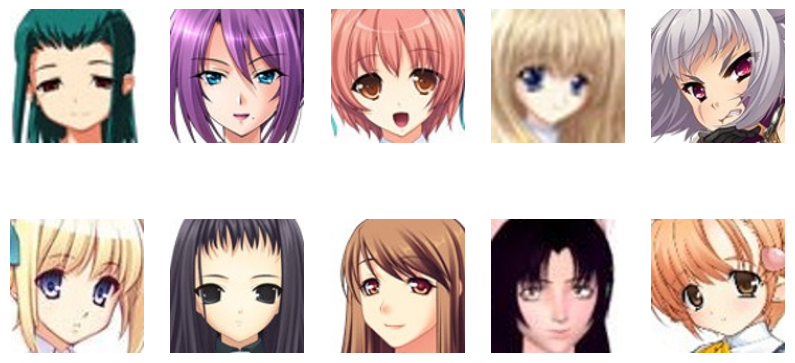

In [3]:
plt.figure(1, figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [4]:
LATENT_DIM = 32
CHANNELS = 3

In [5]:
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

In [6]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

In [7]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False

2023-04-01 20:06:36.326974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-01 20:06:36.327811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [8]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(learning_rate=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

1/1 [==============================] - 0s 10ms/step
50/1000: d_loss: -0.1511,  a_loss: 12.8277.  (9.0 sec)
1/1 [==============================] - 0s 10ms/step
100/1000: d_loss: -0.2190,  a_loss: 47.3478.  (8.9 sec)
1/1 [==============================] - 0s 11ms/step
150/1000: d_loss: 2.7072,  a_loss: 143.5123.  (9.1 sec)
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 11ms/step
200/1000: d_loss: -1.5027,  a_loss: 146.5560.  (9.2 sec)
1/1 [==============================] - 0s 10ms/step
250/1000: d_loss: -0.8469,  a_loss: 87.6186.  (8.9 sec)
1/1 [==============================] - 0s 10ms/step
300/1000: d_loss: 3.8397,  a_loss: 24.7781.  (9.2 sec)
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
350/1000: d_loss: -0.9411,  a_loss: 82.7317.  (9.0 sec)
1/1 [==============================] - 0s 9ms/step
400/1000: d_loss: 1.2312,  a_loss: 8.3094.  (8.9 sec)
1/1 [==============================] - 0s 11ms/step
450/1000: d_loss: -0.5026,  a_loss: 48.7013.  (8.9 sec)
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step
500/1000: d_loss: -0.4790,  a_loss: 71.2813.  (8.9 sec)
1/1 [==============================] - 0s 9ms/step
550/1000: d_loss: -0.0165,  a_loss: 27.1931.  (9.0 sec)
1/1 [==============================] - 0s 11ms/step
600/1000: d_loss: -0.4117,  a_loss: 50.5283.  (8.9 sec)
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
650/1000: d_loss: -0.3156,  a_loss: 43.1497.  (8.9 sec)
1/1 [==============================] - 0s 9ms/step
700/1000: d_loss: -0.3906,  a_loss: 65.1050.  (9.0 sec)
1/1 [==============================] - 0s 11ms/step
750/1000: d_loss: -0.5092,  a_loss: 74.3393.  (8.9 sec)
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step
800/1000: d_loss: -0.9149,  a_loss: 139.3433.  (9.1 sec)
1/1 [==============================] - 0s 9ms/step
850/1000: d_loss: 0.5392,  a_loss: 69.1038.  (8.9 sec)
1/1 [==============================] - 0s 10ms/step
900/1000: d_loss: 0.1761,  a_loss: 42.4129.  (8.9 sec)
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 10ms/step
950/1000: d_loss: -1.2672,  a_loss: 124.5891.  (9.5 sec)
1/1 [==============================] - 0s 10ms/step
1000/1000: d_loss: 0.0143,  a_loss: 72.3403.  (9.2 sec)
2/2 [==============================] - 4s 4s/step


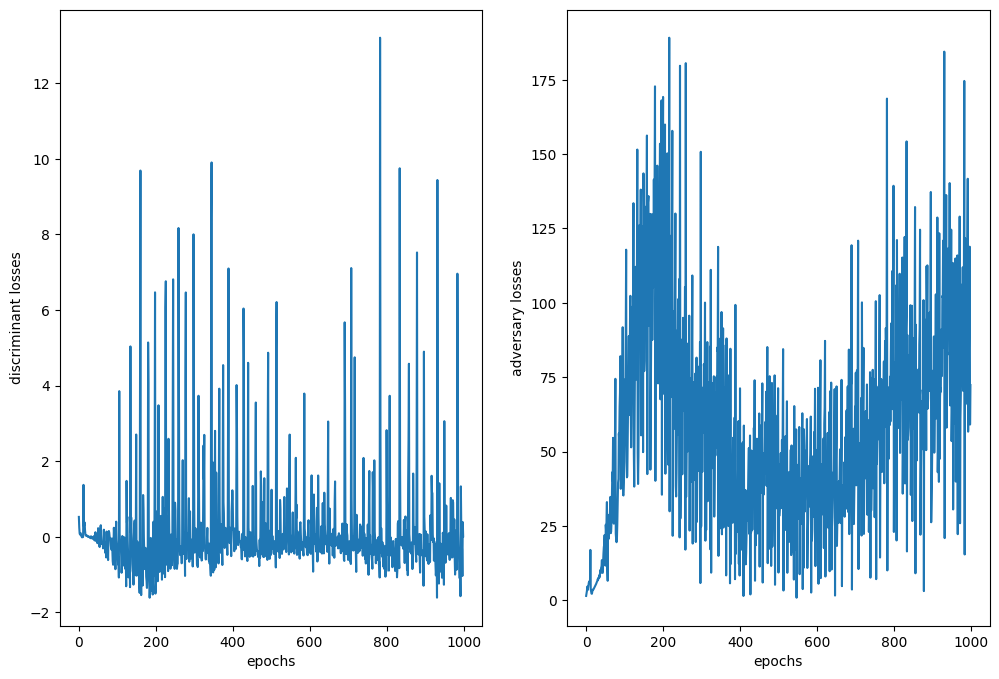

In [11]:
import time
iters = 1000
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights(main_dir + "/HW32_Myshkavets S.A." + '/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

In [16]:
import imageio.v2 as imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave(main_dir + "/HW32_Myshkavets S.A." +'/visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)